## Annotated CycleGAN

As we are building a web app "deepfake" which is of image translation based on GAN model, I present an "annotated" version of the pytorch-based-CycleGAN model in the form of a line-by-line implementation. It will cover data preparation, different GAN models, training schemes, optimization tricks for both training and computation. After completing this notebook, you will know:

- How to implement the discriminator and generator models.
- How to define composite models to train the two aforementioned models via adversarial and cycle loss.
- How to do the model inference to generate the translated image.

To follow along you will first need to install the libraries listed in `requirements-an.txt`. The workflow should be considered as a starting point of image translation tasks with the enrichment of GAN model.

> My comments are blockquoted. The main text is based on the CycleGAN/Pytorch documentation.
> Wangsu Hu (wangsu.hu1234@gmail.com)

## Prelims

In [21]:
!pip install -q -r requirements-an.txt

You should consider upgrading via the '/Users/wangsuhu/Google Drive/Github/pytorch-CycleGAN-and-pix2pix/env/bin/python3 -m pip install --upgrade pip' command.


In [7]:
import matplotlib.pyplot as plt

## Background

The Cycle Generative Adversarial Network, or CycleGAN, is an approach to training a deep convolutional neural network for image-to-image translation tasks.

Unlike other GAN models for image translation, the CycleGAN does not require a dataset of paired images. 

The CycleGAN model was described by Jun-Yan Zhu, et al. in their 2017 paper titled [“Unpaired Image-to-Image Translation using Cycle-Consistent Adversarial Networks.”](https://arxiv.org/abs/1703.10593)

Here is the official github repo released and maintained by the author list [pytorch-CycleGAN-and-pix2pix](https://github.com/junyanz/pytorch-CycleGAN-and-pix2pix). 

The model architecture is comprised of two generator models: 
- one generator (Generator G_A2B) for generating images for the second class (class-B) based on the input image for the first class (class-A)
- another generator (Generator G_B2A) for generating images for the first class (class-A) based on the input image for the second class (class-B)

> as you can see, unlike normal GAN using randomness, the generator of CycleGAN is conditional on the input image and the input image can be a real image or a generated image. See the generator blocks in workflow below.

-- real image for class-A -> G_A2B -> generated image for class-B 
-- generated image for class-A -> G_A2B -> generated image for class-B 
-- real image for class-B -> G_B2A -> generated image for class-A 
-- generated image for class-B -> G_B2A -> generated image for class-A 

- one discriminator (Discriminator D_A) takes images from class-A then predicts whether they are real or fake.
- one discriminator (Discriminator D_B) takes images from class-B then predicts whether they are real or fake.

> similar to generators, the input image of discriminator can be a real image or a generated image.

-- real image for class-A -> D_A -> real/fake
-- generated image for class-A -> D_A -> real/fake
-- real image for class-B -> D_B -> real/fake
-- generated image for class-B -> D_B -> real/fake


Why does sucg GAN model called "Cycle"? 

The discriminator and generator models are trained in an adversarial zero-sum process, like normal GAN models. The generators learn to better fool the discriminators and the discriminator learn to better detect fake images. Together, the models find an equilibrium during the training process.

Additionally, the generator models are regularized to not just create new images in the target domain, but instead translate more reconstructed versions of the input images from the source domain. This is achieved by using generated images as input to the corresponding generator model and comparing the output image to the original images. Passing an image through both generators is called a cycle. Together, each pair of generator models are trained to better reproduce the original source image, referred to as cycle consistency.

-- real image for class-A -> G_A2B -> generated image for class-B -> G_B2A -> generated image for class-A vs the input real image for class-A
-- real image for class-B -> G_B2A -> generated image for class-A -> G_A2B -> generated image for class-B vs the input real image for class-B

see the following flow chart for your reference.

![work_flow](workflow.png)

> we dont consider the "identity mapping" architecture here for simplicity.

## Prepare Data

We prepare the "horses2zebra" dataset which is a subset imagenet dataset and contains around 111 megabytes and can be downloaded from the CycleGAN webpage:

[Download](https://people.eecs.berkeley.edu/~taesung_park/CycleGAN/datasets/horse2zebra.zip)
> after download, put the folder under `annotated_cyclegan/data/`

#### let's first look at what data look like, we randomly selected one image from each class.

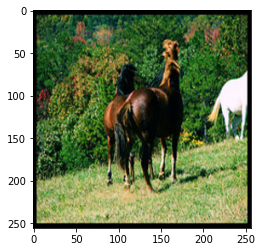

In [13]:
horse_sample = "annotated_cyclegan/data/horse2zebra/testA/n02381460_1000.jpg"
img = plt.imread(horse_sample)
plt.imshow(img)
plt.show()

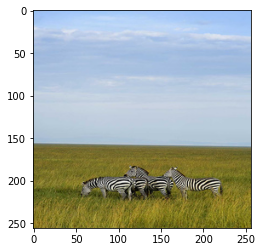

In [14]:
zebra_sample = "annotated_cyclegan/data/horse2zebra/testB/n02391049_100.jpg"
img = plt.imread(zebra_sample)
plt.imshow(img)
plt.show()

As our dataset is not so large (110 MB), we can save them as arrays/vectors then feed into memory later. The normal opt for image pre-processing contains transformation steps such as colorization, scale, crop, and etc. Here we applied what the origin cyclegan paper does, i.e., creating a `UnalignedDataset` which include: 1. load raw image; 2. do 
> the raw class was defined in `data/unaligned_dataset.py`, here we simplify the code for our own cyclegan-only experiment.

In [66]:
def get_transform():
    transform_list = []
    transform_list += [transforms.ToTensor()]
    transform_list += [transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
    return transforms.Compose(transform_list)

In [77]:
import os
from PIL import Image
import torchvision.transforms as transforms
import torch

class UnalignedDataset(torch.utils.data.Dataset):
    """
    This dataset class can load unaligned/unpaired datasets.

    It requires two directories to host training images from domain A '/path/to/data/trainA'
    and from domain B '/path/to/data/trainB' respectively.
    You can train the model with the dataset flag '--dataroot /path/to/data'.
    Similarly, you need to prepare two directories:
    '/path/to/data/testA' and '/path/to/data/testB' during test time.
    """

    def __init__(self, source_class_A_folder, source_class_B_folder):
        """Initialize this dataset class.

        Parameters:
            opt (Option class) -- stores all the experiment flags; needs to be a subclass of BaseOptions
        """
        self.dir_A = source_class_A_folder  # create a path '/path/to/data/trainA'
        self.dir_B = source_class_B_folder  # create a path '/path/to/data/trainB'
        self.transformation = get_transform()
        self.A_images = self.__transform_images__(self.dir_A)
        self.B_images = self.__transform_images__(self.dir_B)
        self.A_size, self.B_size = len(self.A_images), len(self.B_images)
        
        
    def __transform_images__(self, image_folder):
        images = []
        for root, _, fnames in sorted(os.walk(image_folder)):
            for fname in fnames:
                path = os.path.join(root, fname)
                image = Image.open(path).convert('RGB')
                images += [self.transformation(image)]
        return images
    
    
    def __getitem__(self, index):
        """Return a data point and its metadata information.

        Parameters:
            index (int)      -- a random integer for data indexing

        Returns a dictionary that contains A, B, A_paths and B_paths
            A (tensor)       -- an image in the input domain
            B (tensor)       -- its corresponding image in the target domain
            A_paths (str)    -- image paths
            B_paths (str)    -- image paths
        """

        return {'A': self.A_images[index], 'B': self.B_images[index]}

    def __len__(self):
        """Return the total number of images in the dataset.

        As we have two datasets with potentially different number of images,
        we take a maximum of
        """
        return max(self.A_size, self.B_size)



In [78]:
dataset = UnalignedDataset("annotated_cyclegan/data/horse2zebra/trainA/", "annotated_cyclegan/data/horse2zebra/trainB/")